## Phase-2: Data Preprocessing

Step-0a: Data Ingestion and Initial Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Go to your project folder
%cd /content/drive/MyDrive/multimodal_mammography


Mounted at /content/drive
/content/drive/MyDrive/multimodal_mammography


In [ ]:
import importlib.util

def load_module_from_path(name, path):
    spec = importlib.util.spec_from_file_location(name, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module


In [ ]:
# Load environment setup
env = load_module_from_path("env", "setup/environment.py")
install = load_module_from_path("install", "setup/install_colab.py")
_ = load_module_from_path("imports", "setup/imports.py")  # No functions to call

# Run setup
install.install_dependencies()
env.suppress_warnings()
env.set_seed(42)
device = env.get_device()


🔄 Detected Google Colab environment.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.
📦 Installing required packages...
✅ Dependencies installed.
 Warnings suppressed.
🔁 Seed set to 42
 Using device: cuda


Step-0b: Loading Required csvs' and extracting/exploring images


In [ ]:
# ✅ Load the dynamic module
data_loader = load_module_from_path("data_loader", "data/load_data.py")

# ✅ Correct CSV paths
metadata_path    = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/metadata.csv"
breast_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/breast-level_annotations.csv"
finding_anno_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/finding_annotations.csv"

# ✅ Load and view data
metadata_df, breast_df, finding_df = data_loader.load_mammo_data(
    metadata_path,
    breast_anno_path,
    finding_anno_path,
    verbose=False
)


In [ ]:
import pandas as pd

image_df=pd.read_csv("/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_ready.csv")

In [ ]:
print(image_df.columns)

Index(['image_id', 'study_id', 'filename', 'birads', 'birads_dir', 'density',
       'laterality', 'view_position', 'split', 'finding_categories',
       'finding_birads_clean', 'xmin', 'ymin', 'xmax', 'ymax', 'has_bbox',
       'age', 'birads_binary', 'birads_cleaned', 'birads_study_level',
       'finding_mass', 'finding_suspicious_calcification',
       'finding_focal_asymmetry', 'finding_asymmetry',
       'finding_global_asymmetry', 'finding_architectural_distortion',
       'finding_skin_thickening', 'finding_skin_retraction',
       'finding_nipple_retraction', 'finding_suspicious_lymph_node',
       'finding_no_finding'],
      dtype='object')


In [ ]:
import os
import zipfile
import pandas as pd

# Define paths
ZIP_PATH = "/content/drive/MyDrive/multimodal_mammography/dataset/zipped_folder/breast_unprocessed_dataset.zip"
EXTRACT_PATH = "/content/birads_unprocessed_unzipped"

# Extract ZIP safely (skip if already extracted)
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
print("Unzipping complete.")

# Build image_id → path mapping
imageid_to_path = {}
for root, _, files in os.walk(EXTRACT_PATH):
    for file in files:
        if file.lower().endswith(".png"):
            image_id = file.replace(".png", "")
            imageid_to_path[image_id] = os.path.join(root, file)

print(f"Total PNG images mapped: {len(imageid_to_path)}")

# Merge paths into image_df
image_df["image_path"] = image_df["image_id"].map(imageid_to_path)
missing_paths = image_df["image_path"].isna().sum()

print(f"Image paths merged into image_df. Missing paths: {missing_paths}")

# Preview
display(image_df[['image_id', 'image_path', 'birads']].head())


Unzipping complete.
Total PNG images mapped: 19996
Image paths merged into image_df. Missing paths: 0


,image_id,image_path,birads
0,d8125545210c08e1b1793a5af6458ee2,/content/birads_unprocessed_unzipped/normal_un...,2
1,290c658f4e75a3f83ec78a847414297c,/content/birads_unprocessed_unzipped/normal_un...,2
2,cd0fc7bc53ac632a11643ac4cc91002a,/content/birads_unprocessed_unzipped/normal_un...,2
3,71638b1e853799f227492bfb08a01491,/content/birads_unprocessed_unzipped/normal_un...,2
4,dd9ce3288c0773e006a294188aadba8e,/content/birads_unprocessed_unzipped/normal_un...,1


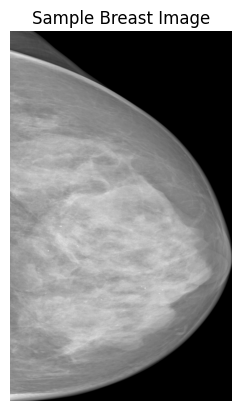

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Pick first valid image path
sample_path = image_df['image_path'].dropna().iloc[0]

# Open and plot
img = Image.open(sample_path)
plt.imshow(img, cmap='gray')
plt.title("Sample Breast Image")
plt.axis('off')
plt.show()


In [ ]:
import os

BASE_PATH = "/content/birads_unprocessed_unzipped"

# Updated to match your actual folder names
for category in ["normal_unprocessed_dataset", "abnormal_unprocessed_dataset"]:
    category_path = os.path.join(BASE_PATH, category)
    print(f"\nCategory: {category}")

    # List first 2 study folders
    study_folders = sorted(os.listdir(category_path))[:2]
    for study in study_folders:
        study_path = os.path.join(category_path, study)
        print(f"  Study: {study}")

        # List up to 4 images inside the study folder
        images = sorted(os.listdir(study_path))[:4]
        for img in images:
            print(f"    {img}")



Category: normal_unprocessed_dataset
  Study: 0025a5dc99fd5c742026f0b2b030d3e9
    2ddfad7286c2b016931ceccd1e2c7bbc.png
    451562831387e2822923204cf8f0873e.png
    47c8858666bcce92bcbd57974b5ce522.png
    fcf12c2803ba8dc564bf1287c0c97d9a.png
  Study: 0028fb2c7f0b3a5cb9a80cb0e1cdbb91
    16e58fc1d65fa7587247e6224ee96527.png
    3704f91985dcbc69f6ac2803523d1ecb.png
    7fc1f1bb8bb1a7efaf7104e49c4d8b86.png
    c4ce68631bf70949570ded31a3c69e60.png

Category: abnormal_unprocessed_dataset
  Study: 003700f3c960e0b9bca2b8437c3dbf05
    17c3d032d611eb3d1baf3434d62483a1.png
    3944b33b99c98e763763b9da54b4f41c.png
    51b47f9024ccad1356354f56ac916f29.png
    552a67df6d68b8f9498db7cadd23b0e0.png
  Study: 008b8e61390fcb4c0873258c15b0a53a
    63d3f4fe3f265d310a1023bcf8336a49.png
    b25443ab817d5590d25b733c1e59192d.png
    e13c80239d7714e3d964b5f3e37bcff6.png
    f1f79501410a98782c0a03b48e66df83.png


In [ ]:
import os

BASE_PATH = "/content/birads_unprocessed_unzipped"

problem_studies = []

for category in ["normal_unprocessed_dataset", "abnormal_unprocessed_dataset"]:
    category_path = os.path.join(BASE_PATH, category)
    print(f"\nScanning category: {category}")

    for study in sorted(os.listdir(category_path)):
        study_path = os.path.join(category_path, study)
        if not os.path.isdir(study_path):
            continue

        images = [img for img in os.listdir(study_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) < 4:
            problem_studies.append({
                "category": category,
                "study": study,
                "n_images": len(images),
                "example_images": images[:4]
            })

print(f"\nTotal problem studies with < 4 images: {len(problem_studies)}")

# Show first 20 as preview
for row in problem_studies[:20]:
    print(row)



Scanning category: normal_unprocessed_dataset

Scanning category: abnormal_unprocessed_dataset

Total problem studies with < 4 images: 0


In [ ]:
import os

BASE_PATH = "/content/birads_unprocessed_unzipped"
categories = ["normal_unprocessed_dataset", "abnormal_unprocessed_dataset"]

summary = {}

for category in categories:
    category_path = os.path.join(BASE_PATH, category)
    study_folders = os.listdir(category_path)

    valid_studies = 0
    invalid_studies = 0

    for study in study_folders:
        study_path = os.path.join(category_path, study)
        images = [f for f in os.listdir(study_path) if f.lower().endswith(".png")]

        if len(images) == 4:
            valid_studies += 1
        else:
            invalid_studies += 1
            print(f"Issue in {category} → {study}: {len(images)} images found")

    summary[category] = {
        "total_studies": len(study_folders),
        "valid_studies": valid_studies,
        "invalid_studies": invalid_studies
    }

print("\nDataset Integrity Summary:")
for cat, stats in summary.items():
    print(f"{cat}: {stats}")



Dataset Integrity Summary:
normal_unprocessed_dataset: {'total_studies': 4518, 'valid_studies': 4518, 'invalid_studies': 0}
abnormal_unprocessed_dataset: {'total_studies': 481, 'valid_studies': 481, 'invalid_studies': 0}


Step 1: Breast Region Detection (BRD) — Gaussian blur, OTSU thresholding, contour detection, and cropping.

In [ ]:
import cv2
import os
import numpy as np

def breast_region_detection(image_path):
    """
    Applies Breast Region Detection (BRD) on a mammogram image.
    Returns the cropped breast region.
    """
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur (5x5 kernel) to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply OTSU thresholding to separate breast from background
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the largest contour (assumed to be the breast)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding rectangle
    cropped = img[y:y+h, x:x+w]

    return cropped


Step-2: Applying CLAHE and Normalization

In [ ]:
def enhance_contrast(cropped_img):
    """
    Applies CLAHE and truncated normalization to the cropped breast region.
    Returns the preprocessed image.
    """
    # --- CLAHE ---
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(cropped_img)

    # --- Truncated normalization ---
    # Compute 5th and 99th percentiles
    lower, upper = np.percentile(clahe_img, [5, 99])

    # Clip the pixel values
    clipped = np.clip(clahe_img, lower, upper)

    # Normalize to 0-255
    norm_img = ((clipped - lower) / (upper - lower) * 255).astype(np.uint8)

    return norm_img


In [ ]:
def preprocess_mammogram(image_path):
    """
    Complete preprocessing pipeline:
    1. Breast Region Detection (BRD)
    2. CLAHE
    3. Truncated Normalization
    Returns the final preprocessed image.
    """
    cropped = breast_region_detection(image_path)
    processed = enhance_contrast(cropped)
    return processed


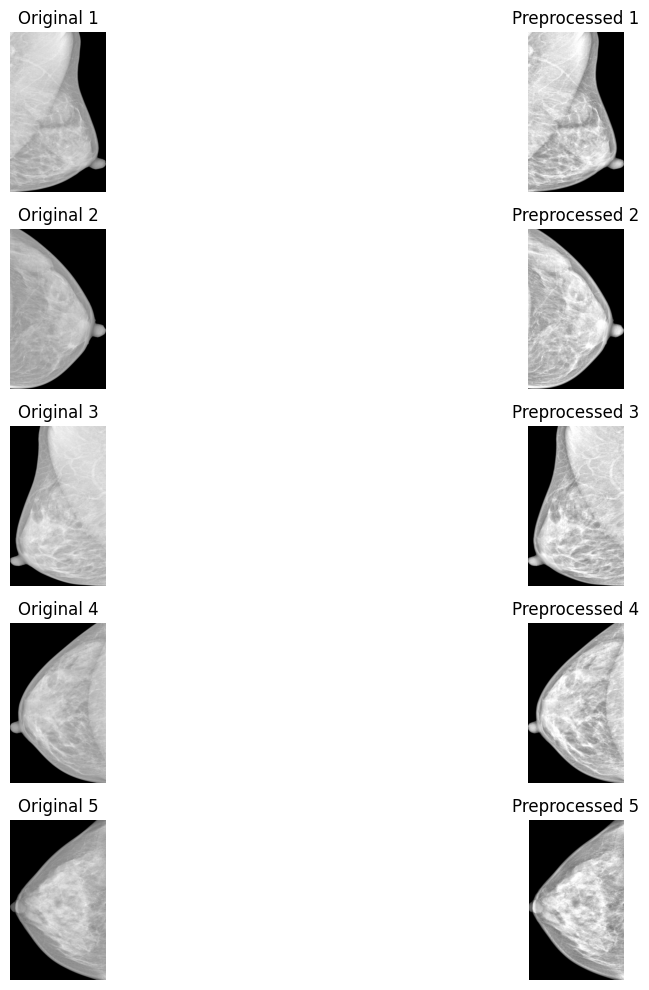

In [ ]:
import matplotlib.pyplot as plt

# Pick five test images (you can select from normal/abnormal folders)
test_images = [
    "/content/birads_unprocessed_unzipped/normal_unprocessed_dataset/0025a5dc99fd5c742026f0b2b030d3e9/2ddfad7286c2b016931ceccd1e2c7bbc.png",
    "/content/birads_unprocessed_unzipped/normal_unprocessed_dataset/0025a5dc99fd5c742026f0b2b030d3e9/451562831387e2822923204cf8f0873e.png",
    "/content/birads_unprocessed_unzipped/normal_unprocessed_dataset/0025a5dc99fd5c742026f0b2b030d3e9/47c8858666bcce92bcbd57974b5ce522.png",
    "/content/birads_unprocessed_unzipped/normal_unprocessed_dataset/0025a5dc99fd5c742026f0b2b030d3e9/fcf12c2803ba8dc564bf1287c0c97d9a.png",
    "/content/birads_unprocessed_unzipped/abnormal_unprocessed_dataset/003700f3c960e0b9bca2b8437c3dbf05/17c3d032d611eb3d1baf3434d62483a1.png"
]

plt.figure(figsize=(15, 10))

for idx, img_path in enumerate(test_images):
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_img = preprocess_mammogram(img_path)

    plt.subplot(5, 2, 2*idx+1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f"Original {idx+1}")
    plt.axis('off')

    plt.subplot(5, 2, 2*idx+2)
    plt.imshow(preprocessed_img, cmap='gray')
    plt.title(f"Preprocessed {idx+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


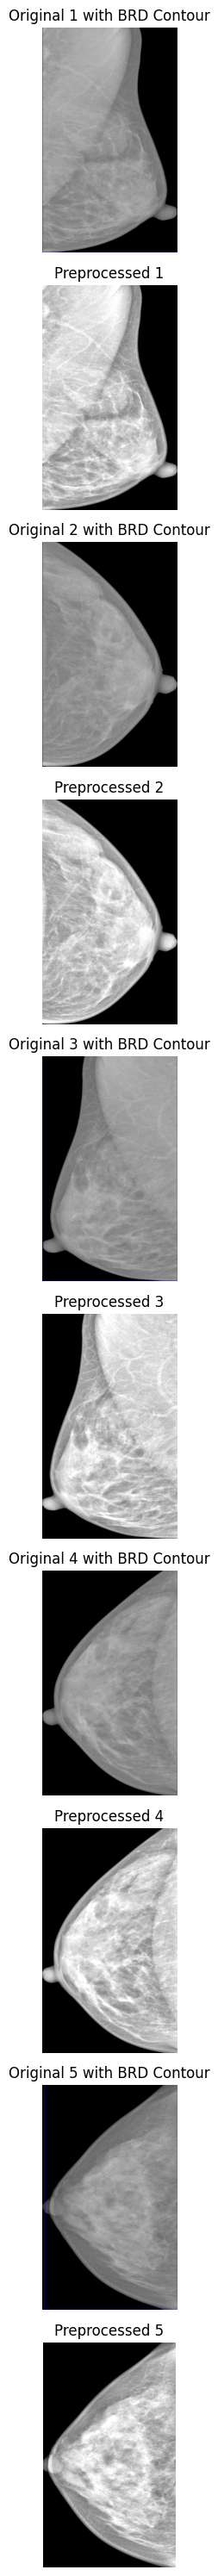

In [ ]:
plt.figure(figsize=(6, 30))  # Taller figure for vertical stacking

for idx, img_path in enumerate(test_images):
    # Read original image
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # --- BRD: Gaussian blur + OTSU + contour detection ---
    blurred = cv2.GaussianBlur(original_img, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw rectangle on original for visualization
    img_rect = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_rect, (x, y), (x+w, y+h), (0, 0, 255), 2)

    # Crop and preprocess
    cropped = original_img[y:y+h, x:x+w]
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(cropped)
    lower, upper = np.percentile(clahe_img, [5, 99])
    processed_img = np.clip(clahe_img, lower, upper)
    processed_img = ((processed_img - lower) / (upper - lower) * 255).astype(np.uint8)

    # Display original with contour
    plt.subplot(10, 1, 2*idx+1)
    plt.imshow(img_rect)
    plt.title(f"Original {idx+1} with BRD Contour")
    plt.axis('off')

    # Display preprocessed
    plt.subplot(10, 1, 2*idx+2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"Preprocessed {idx+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Step-3: Data Upsampling

In [ ]:
for col in image_df.columns:
    print(f"\nColumn: {col}")
    print(image_df[col].value_counts(dropna=False))



Column: image_id
image_id
45c1239cc36b0e672f0072707fd05c6f    1
d8125545210c08e1b1793a5af6458ee2    1
290c658f4e75a3f83ec78a847414297c    1
cd0fc7bc53ac632a11643ac4cc91002a    1
71638b1e853799f227492bfb08a01491    1
                                   ..
500984f90c9b5ddcf00944b0ecc86260    1
0a6a90bdc088e0cc62df8d2d58d14840    1
cb8a1b1282b4b16c0f322e9fc89a9c35    1
7a3df96890c90370590984ca196d1b40    1
1b66d3ea1dae116b7c0e87e3caab3340    1
Name: count, Length: 19996, dtype: int64

Column: study_id
study_id
b3c8969cd2accfa4dbb2aece1f7158ab    4
b8d273e8601f348d3664778dae0e7e0b    4
8269f5971eaca3e5d3772d1796e6bd7a    4
fa4dcd0f3ba24e86fc8dc25091f7ebd5    4
0a0c5108270e814818c1ad002482ce74    4
                                   ..
b738a510998dc553563c344b2e3e684c    4
522963c771a84cb777c49ba7a4ca69fc    4
7ee98232df9bcefc6b54530b6a616690    4
2c314c0a8f364d1a8889bb555d3d04c9    4
9ec3039bf215173edf48a8b4f23ad56a    4
Name: count, Length: 4999, dtype: int64

Column: filename
filename
45

In [ ]:
# Vectorized assignment using birads_study_level
# 0 = Both breasts normal (birads_study_level < 4)
# 1 = Cancer in one breast (birads_study_level == 4)
# 2 = Cancer in both breasts (birads_study_level == 5)
# (Adjust thresholds if needed based on your study definition)

def assign_case_category_study_level(row):
    if row['birads_study_level'] >= 4:  # Cancer present
        if row['birads_study_level'] == 5:
            return 2  # Both breasts cancer (or highest severity)
        else:
            return 1  # One breast cancer
    else:
        return 0  # Both breasts normal

# Apply
image_df['case_category'] = image_df.apply(assign_case_category_study_level, axis=1)

# Check distribution
print(image_df['case_category'].value_counts())


case_category
0    18072
1     1472
2      452
Name: count, dtype: int64


In [ ]:
train_df = image_df[image_df['split'] == 'training'].copy()
test_df  = image_df[image_df['split'] == 'test'].copy()
# Group by study
study_groups = train_df.groupby('study_id')

# Count number of studies per case category
case_counts = train_df.groupby('case_category')['study_id'].nunique()
print("Original study counts per case category:")
print(case_counts)


Original study counts per case category:
case_category
0    3614
1     295
2      90
Name: study_id, dtype: int64


In [ ]:
# Group by study and count images
train_study_counts = train_df.groupby('study_id').size()
test_study_counts  = test_df.groupby('study_id').size()

# Check studies with less than 4 images
train_problem = train_study_counts[train_study_counts < 4]
test_problem  = test_study_counts[test_study_counts < 4]

print(f"Training studies with < 4 images: {len(train_problem)}")
if len(train_problem) > 0:
    print(train_problem)

print(f"\nTest studies with < 4 images: {len(test_problem)}")
if len(test_problem) > 0:
    print(test_problem)


Training studies with < 4 images: 0

Test studies with < 4 images: 0


In [ ]:
from sklearn.utils import resample
import pandas as pd


# Group studies by case category
case_counts = train_df.groupby('case_category')['study_id'].nunique()
print("Original study counts per case category:")
print(case_counts)

target_studies_case1 = 2000  # one-breast cancer
target_studies_case2 = 1000  # both-breast cancer


# Get unique study IDs per category
case1_studies = train_df[train_df['case_category'] == 1]['study_id'].unique()
case2_studies = train_df[train_df['case_category'] == 2]['study_id'].unique()

# Upsample study IDs to target
case1_studies_upsampled = resample(case1_studies, replace=True, n_samples=target_studies_case1, random_state=42)
case2_studies_upsampled = resample(case2_studies, replace=True, n_samples=target_studies_case2, random_state=42)

# Duplicate studies with new study IDs
def duplicate_studies(df, study_ids, prefix):
    duplicated_list = []
    for i, sid in enumerate(study_ids):
        study_rows = df[df['study_id'] == sid].copy()
        study_rows['study_id'] = study_rows['study_id'] + f"_{prefix}{i+1}"
        study_rows['upsampled'] = True
        duplicated_list.append(study_rows)
    return pd.concat(duplicated_list)

case1_upsampled = duplicate_studies(train_df, case1_studies_upsampled, "dup1")
case2_upsampled = duplicate_studies(train_df, case2_studies_upsampled, "dup2")

# Mark original rows
train_df['upsampled'] = False
test_df['upsampled']  = False

# Combine back
image_df_upsampled = pd.concat([train_df, case1_upsampled, case2_upsampled, test_df], ignore_index=True)
image_df_upsampled = image_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify study-level counts after upsampling
study_counts_after = image_df_upsampled[image_df_upsampled['split']=='training'].groupby('case_category')['study_id'].nunique()
print("Study-level counts per case_category after study-wise upsampling:")
print(study_counts_after)

# Optional: save CSV
image_df_upsampled.to_csv("/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv", index=False)


Original study counts per case category:
case_category
0    3614
1     295
2      90
Name: study_id, dtype: int64
Study-level counts per case_category after study-wise upsampling:
case_category
0    3614
1    2295
2    1090
Name: study_id, dtype: int64


In [ ]:
# Group by study and count images
train_study_counts = train_df.groupby('study_id').size()
test_study_counts  = test_df.groupby('study_id').size()

# Check studies with less than 4 images
train_problem = train_study_counts[train_study_counts < 4]
test_problem  = test_study_counts[test_study_counts < 4]

print(f"Training studies with < 4 images: {len(train_problem)}")
if len(train_problem) > 0:
    print(train_problem)

print(f"\nTest studies with < 4 images: {len(test_problem)}")
if len(test_problem) > 0:
    print(test_problem)


Training studies with < 4 images: 0

Test studies with < 4 images: 0


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load your CSV
df = image_df

# Split train/test
train_df = df[df['split'] == 'training'].copy()
test_df  = df[df['split'] == 'test'].copy()

# Check original study counts
print("Original study counts per case category:")
print(train_df.groupby('case_category')['study_id'].nunique())

# Target upsampled numbers
target_case1 = 2000  # one-breast cancer
target_case2 = 1000  # both-breast cancer

# Function to duplicate studies
def duplicate_studies_studywise(df, case_category, target_count, prefix):
    # Get unique study IDs for this case
    studies = df[df['case_category'] == case_category]['study_id'].unique()

    # Upsample study IDs
    upsampled_studies = resample(studies, replace=True, n_samples=target_count, random_state=42)

    # Collect duplicated rows
    duplicated_list = []
    for i, sid in enumerate(upsampled_studies):
        study_rows = df[df['study_id'] == sid].copy()
        # Assign new study ID
        study_rows['study_id'] = study_rows['study_id'] + f"_{prefix}{i+1}"
        study_rows['upsampled'] = True
        duplicated_list.append(study_rows)

    return pd.concat(duplicated_list)

# Mark original rows
train_df['upsampled'] = False
test_df['upsampled']  = False

# Duplicate case 1 and case 2 studies
case1_upsampled = duplicate_studies_studywise(train_df, case_category=1, target_count=target_case1, prefix="dup1")
case2_upsampled = duplicate_studies_studywise(train_df, case_category=2, target_count=target_case2, prefix="dup2")

# Combine everything back
df_upsampled = pd.concat([train_df, case1_upsampled, case2_upsampled, test_df], ignore_index=True)
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify study-level counts after upsampling
study_counts_after = df_upsampled[df_upsampled['split'] == 'training'].groupby('case_category')['study_id'].nunique()
print("Study-level counts per case_category after study-wise upsampling:")
print(study_counts_after)

# Verify that every study has at least 4 images
study_image_counts = df_upsampled.groupby('study_id').size()
problem_studies = study_image_counts[study_image_counts < 4]
print(f"Studies with < 4 images after upsampling: {len(problem_studies)}")
if len(problem_studies) > 0:
    print(problem_studies)

# Save CSV
df_upsampled.to_csv("/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv", index=False)


Original study counts per case category:
case_category
0    3614
1     295
2      90
Name: study_id, dtype: int64
Study-level counts per case_category after study-wise upsampling:
case_category
0    3614
1    2295
2    1090
Name: study_id, dtype: int64
Studies with < 4 images after upsampling: 0


In [ ]:
import pandas as pd

# Load the upsampled CSV
csv_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv"
df = pd.read_csv(csv_path)

# Group by study_id and count images
study_image_counts = df.groupby('study_id').size()

# Check studies with less than 4 images
problem_studies = study_image_counts[study_image_counts < 4]

print(f"Total studies with < 4 images: {len(problem_studies)}")
if len(problem_studies) > 0:
    print(problem_studies)
else:
    print("✅ All studies have at least 4 images.")


Total studies with < 4 images: 0
✅ All studies have at least 4 images.


Step-4: Applying preprocessing to all studies

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import cv2

# Load upsampled CSV
csv_path = "/content/drive/MyDrive/multimodal_mammography/dataset/csv/image_df_upsampled_studywise.csv"
df = pd.read_csv(csv_path)

# Base folder for preprocessed images
PREPROC_BASE = "/content/birads_preprocessed_dataset"
os.makedirs(PREPROC_BASE, exist_ok=True)

preprocessed_paths = []

# Group by split and study
for split in df['split'].unique():
    split_df = df[df['split'] == split]
    study_ids = split_df['study_id'].unique()

    for study_id in tqdm(study_ids, desc=f"Processing {split} studies"):
        study_df = split_df[split_df['study_id'] == study_id]
        label = "normal" if study_df['birads_binary'].iloc[0] == "normal" else "abnormal"

        save_folder = os.path.join(PREPROC_BASE, split, label, study_id)
        os.makedirs(save_folder, exist_ok=True)

        for idx, row in study_df.iterrows():
            img_id = row['image_id']
            image_path = row['image_path']

            # Preprocess
            processed_img = preprocess_mammogram(image_path)

            # Save
            save_path = os.path.join(save_folder, f"{img_id}.png")
            cv2.imwrite(save_path, processed_img)

            preprocessed_paths.append(save_path)

# Update CSV
df['preprocessed_path'] = preprocessed_paths
df.to_csv(os.path.join(PREPROC_BASE, "image_df_upsampled_preprocessed.csv"), index=False)

print("✅ All images preprocessed and saved with normal/abnormal structure (study-wise).")


Processing test studies: 100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s]


✅ All images preprocessed and saved with normal/abnormal structure (study-wise).


In [ ]:
import os
from pathlib import Path
from PIL import Image

PREPROC_BASE = "/content/birads_preprocessed_dataset"

splits = ["training", "test"]
labels = ["normal", "abnormal"]

summary = {}

for split in splits:
    summary[split] = {}
    split_path = Path(PREPROC_BASE) / split
    for label in labels:
        label_path = split_path / label
        if not label_path.exists():
            summary[split][label] = {"num_studies": 0, "num_images": 0}
            continue

        studies = sorted(label_path.iterdir())
        num_studies = len(studies)
        num_images = sum(len(list(study.iterdir())) for study in studies)

        summary[split][label] = {
            "num_studies": num_studies,
            "num_images": num_images
        }

        # Preview first image from first study
        if num_studies > 0:
            first_study = studies[0]
            first_images = sorted(first_study.iterdir())
            if first_images:
                img_path = first_images[0]
                img = Image.open(img_path)
                print(f"\nPreview - {split}/{label}/Study {first_study.name}/Image {img_path.name}")
                print(f"Size: {img.size}, Mode: {img.mode}")

# Print summary table
print("\n=== Dataset Summary ===")
for split in summary:
    print(f"\nSplit: {split}")
    for label in summary[split]:
        info = summary[split][label]
        print(f"  Label: {label} | Studies: {info['num_studies']} | Images: {info['num_images']}")



Preview - training/normal/Study 0028fb2c7f0b3a5cb9a80cb0e1cdbb91/Image 16e58fc1d65fa7587247e6224ee96527.png
Size: (909, 1519), Mode: L

Preview - training/abnormal/Study 003700f3c960e0b9bca2b8437c3dbf05/Image 17c3d032d611eb3d1baf3434d62483a1.png
Size: (895, 1520), Mode: L

Preview - test/normal/Study 0025a5dc99fd5c742026f0b2b030d3e9/Image 2ddfad7286c2b016931ceccd1e2c7bbc.png
Size: (910, 1520), Mode: L

Preview - test/abnormal/Study 014d843f13a9d86fec945664e2541fe6/Image 44b20cab46f81d4836d7bcdfba9f5125.png
Size: (908, 1520), Mode: L

=== Dataset Summary ===

Split: training
  Label: normal | Studies: 5065 | Images: 20260
  Label: abnormal | Studies: 1934 | Images: 7736

Split: test
  Label: normal | Studies: 916 | Images: 3664
  Label: abnormal | Studies: 84 | Images: 336


In [ ]:
import os

PREPROC_BASE = "/content/birads_preprocessed_dataset"
splits = ["training", "test"]
labels = ["normal", "abnormal"]

problem_studies = []

for split in splits:
    for label in labels:
        split_label_path = os.path.join(PREPROC_BASE, split, label)
        if not os.path.exists(split_label_path):
            continue
        for study_id in os.listdir(split_label_path):
            study_path = os.path.join(split_label_path, study_id)
            images = [f for f in os.listdir(study_path) if f.lower().endswith(".png")]
            if len(images) < 4:
                problem_studies.append((split, label, study_id, len(images)))

if problem_studies:
    print(f"Total problem studies with < 4 images: {len(problem_studies)}")
    for split, label, study_id, n_imgs in problem_studies:
        print(f"{split}/{label}/{study_id}: {n_imgs} images")
else:
    print("✅ All studies have 4 or more images.")


✅ All studies have 4 or more images.


In [ ]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm

PREPROC_BASE = "/content/birads_preprocessed_dataset"
splits = ["training", "test"]
labels = ["normal", "abnormal"]

all_sizes = []

for split in splits:
    for label in labels:
        label_path = Path(PREPROC_BASE) / split / label
        if not label_path.exists():
            continue

        studies = list(label_path.iterdir())
        for study in tqdm(studies, desc=f"Processing {split}/{label} studies"):
            images = list(study.iterdir())
            for img_path in images:
                img = Image.open(img_path)
                if img.mode != "L":
                    print(f"Warning: {img_path} mode = {img.mode}")
                all_sizes.append(img.size)

# Convert to numpy array for stats
all_sizes_np = np.array(all_sizes)

widths = all_sizes_np[:, 0]
heights = all_sizes_np[:, 1]

print("\n=== Image Size Statistics ===")
print(f"Total images checked: {len(all_sizes)}")
print(f"Width  -> min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.2f}")
print(f"Height -> min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.2f}")

# Optional: unique sizes
unique_sizes = np.unique(all_sizes_np, axis=0)
print(f"Unique image sizes: {len(unique_sizes)}")
print("Some examples:", unique_sizes[:5])


Processing test/abnormal studies: 100%|██████████| 84/84 [00:00<00:00, 1985.42it/s]



=== Image Size Statistics ===
Total images checked: 31996
Width  -> min: 436, max: 912, mean: 905.09
Height -> min: 1019, max: 1520, mean: 1519.04
Unique image sizes: 422
Some examples: [[ 436 1520]
 [ 630 1520]
 [ 730 1520]
 [ 732 1520]
 [ 741 1520]]


Step-4: Zipping and saving to drive

In [ ]:
import os
import zipfile
from tqdm import tqdm
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Paths
dataset_path = "/content/birads_preprocessed_dataset"  # Your preprocessed dataset folder
zip_path = "/content/birads_preprocessed_dataset.zip"
drive_dest = "/content/drive/MyDrive/birads_preprocessed_dataset.zip"

# Function to zip folder with tqdm
def zip_with_progress(folder_path, zip_name):
    # Collect all file paths
    file_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))

    # Zip using tqdm
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in tqdm(file_paths, desc="Zipping files"):
            arcname = os.path.relpath(file, folder_path)  # Keep folder structure
            zipf.write(file, arcname=arcname)

# Zip the dataset
zip_with_progress(dataset_path, zip_path)
print("Zipping complete!")

# Copy zip to Google Drive
shutil.copy(zip_path, drive_dest)
print(f"Dataset copied to Google Drive at: {drive_dest}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Zipping files: 100%|██████████| 31997/31997 [12:22<00:00, 43.09it/s]


Zipping complete!
Dataset copied to Google Drive at: /content/drive/MyDrive/birads_preprocessed_dataset.zip
